In [1]:
import lionagi as li
from pydantic import Field
from lionagi.libs import SysUtil

In [2]:
import importlib
import subprocess
import sys

def install_library(library):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        print(f"Successfully installed {library}.")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while installing {library}: {str(e)}")
        print("Please check the error message and ensure you have the necessary permissions to install packages.")
        print("You may need to run the script with administrative privileges or use a virtual environment.")

def is_library_installed(library):
    try:
        importlib.import_module(library)
        return True
    except ImportError:
        return False

def install_missing_dependencies(required_libraries):
    print("Checking for missing dependencies...")
    missing_libraries = [
        library
        for library in required_libraries
        if not is_library_installed(library)
    ]

    if missing_libraries:
        print(f"Missing libraries: {', '.join(missing_libraries)}")
        for library in missing_libraries:
            print(f"Installing {library}...")
            install_library(library)
    else:
        print("All required dependencies are already installed.")

def set_up_interpreter(interpreter_provider="e2b", **kwargs):
    print(f"Setting up interpreter with provider: {interpreter_provider}")
    if interpreter_provider == "e2b":
        SysUtil.check_import("e2b_code_interpreter")
        from e2b_code_interpreter import CodeInterpreter
        
        return CodeInterpreter(**kwargs)
    else:
        raise ValueError("Invalid interpreter provider")

def handle_error(execution, required_libraries):
    if execution.error and execution.error.name == 'ModuleNotFoundError':
        install_missing_dependencies(required_libraries)
        return "try again"
    elif execution.error:
        return execution.error


In [3]:
GUIDANCE_RESPONSE = """
    Guidance from super intelligent code bot:
    {guidance_response}
    Please generate Python functions that satisfies the prompt and follows the provided guidance, while adhering to these coding standards:
    - Use descriptive and meaningful names for variables, functions, and classes.
    - Follow the naming conventions: lowercase with underscores for functions and variables, CamelCase for classes.
    - Keep functions small and focused, doing one thing well.
    - Use 4 spaces for indentation, and avoid mixing spaces and tabs.
    - Limit line length to 79 characters for better readability.
    - Use docstrings to document functions, classes, and modules, describing their purpose, parameters, and return values.
    - Use comments sparingly, and prefer descriptive names and clear code structure over comments.
    - Handle exceptions appropriately and raise exceptions with clear error messages.
    - Use blank lines to separate logical sections of code, but avoid excessive blank lines.
    - Import modules in a specific order: standard library, third-party, and local imports, separated by blank lines.
    - Use consistent quotes (single or double) for strings throughout the codebase.
    - Follow the PEP 8 style guide for more detailed coding standards and best practices.
"""

PLAN_PROMPT = "Please design coding instructions for the following prompt and provide guidance for the coder to follow."
WRITE_PROMPT = "Please write a Python function that satisfies the prompt and follows the provided guidance."
REVIEW_PROMPT = "Please review the following code and remove any unnecessary markdown or descriptions:\n\n{code}\n"
DEBUG_PROMPT = """
please debug the code, fix the error and provide the correctly updated code to satisfy the prompt according to the guidance provided.
 ### code: \n\n {code}\n , ran into the following 
 ### error: \n\n {error}\n
"""

CODER_PROMPTS = {
    "system": GUIDANCE_RESPONSE,
    "plan_code": PLAN_PROMPT,
    "write_code": WRITE_PROMPT,
    "debug_code": DEBUG_PROMPT,
    "review_code": REVIEW_PROMPT,
}

In [4]:
class CoderForm(li.Form):
    """
    A form template for developing software project
    """

    template_name: str = "coder template"

    context: str | None= Field(
        None,
        title="Context",
        description="The context for the current issue to achieve",
    )

    plan: str | None = Field(
        None,
        title="Plan",
        description=" breaking down the issue to multi-step plan",
    )

    code: str | None = Field(
        None,
        title="Code",
        description="codes generated by workflow",
    )

    review: str | None = Field(
        None,
        title="review",
        description="comments on generated code"
    )

In [5]:
class DebugForm(li.Form):
    """
    A form template for debugging
    """

    template_name: str = "debug template"

    context: str | None= Field(
        None,
        title="Context",
        description="The context for the current issue to achieve",
    )
    
    code: str | None = Field(
        None,
        title="Code",
        description="codes generated by workflow",
    )

    error: str | None = Field(
        None,
        title="Error",
        description="error raised when executing code"
    )
    
    updated_code: str | None = Field(
        None,
        title="Updated code",
        description="modified codes according to error raised"
    )

In [6]:
class Coder(li.Worker):
    name = "coder"

    def __init__(self, required_libraries=None):
        super().__init__()
        self.issues = []
        self.unsolved_bugs=[]
        self.tasks = {}
        self.required_libraries = required_libraries or ["lionagi"]
    
    async def _update_form(self, work):
        if work.status == "COMPLETED":
            if work.async_task_name == "_plan_code":
                form_key = work.result.context
                self.forms[form_key].plan = getattr(work.result, "plan")
            elif work.async_task_name == "_execute_code" and work.result.error is None:
                form_key = work.result.context
                self.forms[form_key].code = getattr(work.result, "code")
            elif work.async_task_name == "_review_code":
                form_key = work.result.context
                self.forms[form_key].review = getattr(work.result, "review")
    
    async def _update_debug_form(self, work):
        if work.status == "COMPLETED":
            if work.async_task_name == "_debug_code":
                original_form = work.result.origin
                original_form.updated_code = getattr(work.result, "updated_code")
    
    @li.work(capacity=2, refresh_time=0.1)
    async def create_new_issue(self, issue):
        print(f"*****\nCreate issue: \n----------\n{issue}\n----------\n**")
        new_issue_report = CoderForm(context = issue)
        self.forms[issue] = new_issue_report
        self.issues.append(issue)
        return issue

    @li.work(assignment="context -> plan", form_param_key="issue", guidance=CODER_PROMPTS["plan_code"], capacity=2, refresh_time=0.1)
    async def _plan_code(self, issue, **kwargs):
        if issue not in self.issues:
            raise ValueError("Issue is not found. Please create_new_issue first.")
        print(f"*****\nPlanning code for issue: \n----------\n{issue}\n----------\n**")
        result = await li.direct.chat(system=CODER_PROMPTS["system"], **kwargs)
        print(f"*****\nCode plan generated for issue: \n----------\n{issue}\n----------\n**")
        return result
    
    @li.work(assignment="context, plan -> code", form_param_key="issue", guidance=CODER_PROMPTS["write_code"], capacity=2, refresh_time=0.1)
    async def _write_code(self, issue, **kwargs):
        if issue not in self.issues:
            raise ValueError("Issue is not found. Please create_new_issue first.")
        print(f"*****\nWriting code for issue: \n----------\n{issue}\n----------\n**")
        result = await li.direct.chat(system=CODER_PROMPTS["system"], **kwargs)
        print(f"*****\nCode written for issue: \n----------\n{issue}\n----------\n**")
        return result
    
    @li.work(capacity=1, refresh_time=0.5)
    async def _execute_code(self, context, code, interpreter_kwargs={}, **kwargs):
        print(f"*****\nExecuting code for issue: \n----------\n{context}\n----------\n**")
        with set_up_interpreter(**interpreter_kwargs) as sandbox:
            execution = sandbox.notebook.exec_cell(code, **kwargs)
            error = handle_error(execution, required_libraries=self.required_libraries)
            if error == "try again":
                execution = sandbox.notebook.exec_cell(code, **kwargs)
            print(f"*****\nCode execution completed for issue: \n----------\n{context}\n----------\n**")
            if error is not None:
                result = DebugForm(context=context, code=code, error=execution.error.traceback)
                self.forms[result.ln_id] = result
            else:
                result = DebugForm(context=context, code=code)
            return result
    
    @li.work(assignment="context, code, error -> updated_code", form_param_key="bug_form_id", guidance=CODER_PROMPTS["debug_code"], capacity=1, refresh_time=0.1)
    async def _debug_code(self, bug_form_id, **kwargs):
        print(f"*****\nDebugging code for issue: \n----------\n{self.forms[bug_form_id].context}\n----------\n**")
        result = await li.direct.chat(system=CODER_PROMPTS["system"], **kwargs)
        print(f"*****\nCode debugging completed for issue: \n----------\n{self.forms[bug_form_id].context}\n----------\n**")
        return result

    @li.work(assignment="context, code -> review", form_param_key="issue", guidance=CODER_PROMPTS["review_code"], capacity=2, refresh_time=0.1)
    async def _review_code(self, issue, **kwargs):
        if issue not in self.issues:
            raise ValueError("Issue is not found. Please create_new_issue first.")
        print(f"*****\nReviewing code for issue: \n----------\n{issue}\n----------\n**")
        result = await li.direct.chat(system=CODER_PROMPTS["system"], **kwargs)
        print(f"*****\nCode reviewed for issue: \n----------\n{issue}\n----------\n**")
        return result

    @li.worklink(from_="create_new_issue", to_="_plan_code")
    async def create_to_plan(self, from_result):
        return {"issue": from_result}
    
    @li.worklink(from_="_plan_code", to_="_write_code")
    async def plan_to_write(self, from_work):
        await self._update_form(from_work)
        return {"issue": from_work.result.context}
    
    @li.worklink(from_="_write_code", to_="_execute_code")
    async def write_to_execute(self, from_result):
        return {"context": from_result.context, "code": from_result.code}
    
    @li.worklink(from_="_execute_code", to_="_debug_code")
    async def execute_to_debug(self, from_result):
        if from_result.error is not None:
            return {"bug_form_id": from_result.ln_id}

    @li.worklink(from_="_debug_code", to_="_execute_code")
    async def debug_to_execute(self, from_result, from_work):
        await self._update_debug_form(from_work)
        return {"context": from_result.context, "code": from_result.updated_code}

    @li.worklink(from_="_execute_code", to_="_review_code")
    async def execute_to_review(self, from_work, from_result):
        if from_result.error is None:
            await self._update_form(from_work)
            return {"issue": from_result.context}

    async def post_processing(self, task):
        await self._update_form(task.work_history[-1])


In [7]:
from lionagi.core.work.worker_engine import WorkerEngine

In [8]:
coder = Coder()

In [9]:
coder_engine = WorkerEngine(worker=coder, refresh_time=0.3)

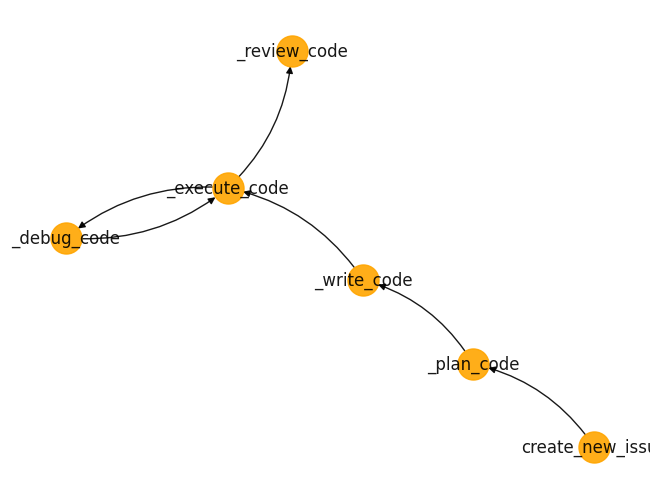

In [10]:
coder_engine.worker_graph.display(node_label="name", draw_kwargs={"connectionstyle": "arc3, rad = 0.2"})
# coder_engine.worker_graph.display(node_label="name", edge_label="name", draw_kwargs={"connectionstyle": "arc3, rad = 0.2"})

In [11]:
# schedule tasks
task1 = await coder_engine.add_task("write a python function that takes a numpy of integers and returns the sum.", 
                   task_function="create_new_issue",
                   task_post_processing=coder.post_processing)  # The post-processing function to be executed after the entire task has been completed.

In [12]:
await coder_engine.execute()

*****
Create issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Planning code for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Code plan generated for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Writing code for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Code written for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Executing code for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
Setting up interpreter with provider: e2b
*****
Code execution completed for issue: 
----------
write a python function that takes a numpy of integers and returns the sum.
----------
**
*****
Reviewing code f

In [13]:
for work in task1.work_history:
    print(f"Work {work.async_task_name}:")
    display(work)
    print("Result:")
    display(work.result)

Work create_new_issue:


ln_id                                    36a912548249dd3de1272db79b0aabc6
created                                        2024-06-14T15:09:58.923260
metadata                {'last_updated': {'status': '2024-06-14T15:09:...
content                                                              None
embedding                                                              []
status                                               WorkStatus.COMPLETED
result                  write a python function that takes a numpy of ...
error                                                                None
async_task_name                                          create_new_issue
completion_timestamp                           2024-06-14T15:09:58.927208
duration                                                         0.000187
lion_class                                                           Work
dtype: object

Result:


'write a python function that takes a numpy of integers and returns the sum.'

Work _plan_code:


ln_id                                    8756f84e31b14465e3a4f685499a9ea7
created                                        2024-06-14T15:09:59.533938
metadata                {'last_updated': {'status': '2024-06-14T15:09:...
content                                                              None
embedding                                                              []
status                                               WorkStatus.COMPLETED
result                  {'ln_id': 'fcf6b54515316c3688c5596f55cef031', ...
error                                                                None
async_task_name                                                _plan_code
completion_timestamp                           2024-06-14T15:10:09.636536
duration                                                          9.79899
lion_class                                                           Work
dtype: object

Result:


ln_id                                 fcf6b54515316c3688c5596f55cef031
created                                     2024-06-14T15:09:59.533821
metadata             {'last_updated': {'input_fields': '2024-06-14T...
content                                                           None
embedding                                                           []
template_name                                           coder template
assignment                                             context -> plan
input_fields                                                 [context]
requested_fields                                                [plan]
task                 Please design coding instructions for the foll...
validation_kwargs                                                   {}
context              write a python function that takes a numpy of ...
plan                 To write a Python function that takes a numpy ...
code                                                              None
review

Work _write_code:


ln_id                                    fd0fd494b39406f9ba94f133729a12d0
created                                        2024-06-14T15:10:10.084656
metadata                {'last_updated': {'status': '2024-06-14T15:10:...
content                                                              None
embedding                                                              []
status                                               WorkStatus.COMPLETED
result                  {'ln_id': 'a2edd5212d79aeedfa06eb0e836e961a', ...
error                                                                None
async_task_name                                               _write_code
completion_timestamp                           2024-06-14T15:10:14.550600
duration                                                         4.086952
lion_class                                                           Work
dtype: object

Result:


ln_id                                 a2edd5212d79aeedfa06eb0e836e961a
created                                     2024-06-14T15:10:10.084257
metadata             {'last_updated': {'input_fields': '2024-06-14T...
content                                                           None
embedding                                                           []
template_name                                           coder template
assignment                                       context, plan -> code
input_fields                                           [context, plan]
requested_fields                                                [code]
task                 Please write a Python function that satisfies ...
validation_kwargs                                                   {}
context              write a python function that takes a numpy of ...
plan                 To write a Python function that takes a numpy ...
code                 import numpy as np\n\n\ndef sum_numpy_array(ar...
review

Work _execute_code:


ln_id                                    d8ada83f2b1e33be2ab765dd463fce19
created                                        2024-06-14T15:10:14.604973
metadata                {'last_updated': {'status': '2024-06-14T15:10:...
content                                                              None
embedding                                                              []
status                                               WorkStatus.COMPLETED
result                  {'ln_id': '87bbb925490bfcfe6fbb8ed484cd611f', ...
error                                                                None
async_task_name                                             _execute_code
completion_timestamp                           2024-06-14T15:10:19.361316
duration                                                         4.286859
lion_class                                                           Work
dtype: object

Result:


ln_id                                 87bbb925490bfcfe6fbb8ed484cd611f
created                                     2024-06-14T15:10:19.361183
metadata             {'last_updated': {'input_fields': '2024-06-14T...
content                                                           None
embedding                                                           []
template_name                                           debug template
assignment                                                        None
input_fields                                                        []
requested_fields                                                    []
task                                                                  
validation_kwargs                                                   {}
context              write a python function that takes a numpy of ...
code                 import numpy as np\n\n\ndef sum_numpy_array(ar...
error                                                             None
update

Work _review_code:


ln_id                                    cb0db14321521e6025d496af49f1e441
created                                        2024-06-14T15:10:19.662894
metadata                {'last_updated': {'status': '2024-06-14T15:10:...
content                                                              None
embedding                                                              []
status                                               WorkStatus.COMPLETED
result                  {'ln_id': '372b23efaa219cc61c1aa5503129a2fa', ...
error                                                                None
async_task_name                                              _review_code
completion_timestamp                           2024-06-14T15:10:24.588683
duration                                                         4.622554
lion_class                                                           Work
dtype: object

Result:


ln_id                                 372b23efaa219cc61c1aa5503129a2fa
created                                     2024-06-14T15:10:19.662802
metadata             {'last_updated': {'input_fields': '2024-06-14T...
content                                                           None
embedding                                                           []
template_name                                           coder template
assignment                                     context, code -> review
input_fields                                           [context, code]
requested_fields                                              [review]
task                 Please review the following code and remove an...
validation_kwargs                                                   {}
context              write a python function that takes a numpy of ...
plan                                                              None
code                 import numpy as np\n\n\ndef sum_numpy_array(ar...
review

In [14]:
coder.forms

{'write a python function that takes a numpy of integers and returns the sum.': ln_id                                 e3883b3aed61fd72fb1070ad84c28922
 created                                     2024-06-14T15:09:58.927130
 metadata             {'last_updated': {'input_fields': '2024-06-14T...
 content                                                           None
 embedding                                                           []
 template_name                                           coder template
 assignment                                                        None
 input_fields                                                        []
 requested_fields                                                    []
 task                                                                  
 validation_kwargs                                                   {}
 context              write a python function that takes a numpy of ...
 plan                 To write a Python function that tak

# Max_steps

In [15]:
task2_a = await coder_engine.add_task("Write a pure python function that takes a list of integers and returns a dictionary where the keys are the integers from the list and the values are the counts of how many times each integer appears in the list.", 
                   task_function="create_new_issue",
                   task_max_steps=1, # default to 10
                   task_post_processing=coder.post_processing)

In [16]:
await coder_engine.execute()

*****
Create issue: 
----------
Write a pure python function that takes a list of integers and returns a dictionary where the keys are the integers from the list and the values are the counts of how many times each integer appears in the list.
----------
**


# Start at any step

In [17]:
# make sure all info is complete
# in this case, issue has been added to the task's form before _plan_code
task2_b = await coder_engine.add_task("Write a pure python function that takes a list of integers and returns a dictionary where the keys are the integers from the list and the values are the counts of how many times each integer appears in the list.", 
                   task_function="_plan_code",
                   task_max_steps=1,
                   task_post_processing=coder.post_processing)

In [18]:
await coder_engine.execute()

*****
Planning code for issue: 
----------
Write a pure python function that takes a list of integers and returns a dictionary where the keys are the integers from the list and the values are the counts of how many times each integer appears in the list.
----------
**
*****
Code plan generated for issue: 
----------
Write a pure python function that takes a list of integers and returns a dictionary where the keys are the integers from the list and the values are the counts of how many times each integer appears in the list.
----------
**


# Keep running engine

In [19]:
await coder_engine.execute_lasting() # Executes tasks continuously until engine is stopped

*****
Create issue: 
----------
write a pure python function that takes a list of integers and returns the maximum integer in the list.
----------
**
*****
Planning code for issue: 
----------
write a pure python function that takes a list of integers and returns the maximum integer in the list.
----------
**
*****
Create issue: 
----------
Write a pure Python function that takes a list of integers and returns a new list containing only the even integers from the original list.
----------
**
*****
Code plan generated for issue: 
----------
write a pure python function that takes a list of integers and returns the maximum integer in the list.
----------
**
*****
Writing code for issue: 
----------
write a pure python function that takes a list of integers and returns the maximum integer in the list.
----------
**
*****
Code written for issue: 
----------
write a pure python function that takes a list of integers and returns the maximum integer in the list.
----------
**
*****
Executing 

In [20]:
task3 = await coder_engine.add_task("write a pure python function that takes a list of integers and returns the maximum integer in the list.", 
                   task_function="create_new_issue",
                   task_post_processing=coder.post_processing)

In [21]:
task4 = await coder_engine.add_task("Write a pure Python function that takes a list of integers and returns a new list containing only the even integers from the original list.", 
                   task_function="create_new_issue",
                   task_post_processing=coder.post_processing)

In [26]:
coder_engine.tasks

                              ln_id                     created  \
0  ed4c00d1b5427a32e5287560e10eb6b3  2024-06-14T15:09:58.923211   
1  fb6a7e00f03a049b49fc62e69b2eab64  2024-06-14T15:10:25.211479   
2  86c0d53e29b047e0b4140a93b8db08ad  2024-06-14T15:10:26.136181   
3  599d0f1fc78056233e6a1234b248972c  2024-06-14T15:11:19.656889   
4  e4bf17b9ce8db84bfa0a0ba492e68b59  2024-06-14T15:11:23.714911   

                                            metadata content embedding  name  \
0  {'last_updated': {'current_work': '2024-06-14T...    None        []  None   
1  {'last_updated': {'current_work': '2024-06-14T...    None        []  None   
2  {'last_updated': {'current_work': '2024-06-14T...    None        []  None   
3  {'last_updated': {'current_work': '2024-06-14T...    None        []  None   
4  {'last_updated': {'current_work': '2024-06-14T...    None        []  None   

                 status                                        status_note  \
0  WorkStatus.COMPLETED               

# Stop running engine and running work functions

In [27]:
await coder_engine.stop() # stop running engine
await coder_engine.worker.stop() # stop running work functions